In [2]:
# Prepare

%matplotlib notebook

import numpy as np
import pylab as plt
import seaborn as sns; sns.set()
import pandas as pd
import matplotlib
import scipy
import time
import warnings

from scipy import sparse
from sklearn.linear_model import LinearRegression

sns.set_style('ticks')

import sparseRRR

def sns_styleset():
    sns.set(context='paper', style='ticks', font='Arial')
    matplotlib.rcParams['axes.linewidth']    = .5
    matplotlib.rcParams['xtick.major.width'] = .5
    matplotlib.rcParams['ytick.major.width'] = .5
    matplotlib.rcParams['xtick.minor.width'] = .5
    matplotlib.rcParams['ytick.minor.width'] = .5
    matplotlib.rcParams['xtick.major.size'] = 2
    matplotlib.rcParams['ytick.major.size'] = 2
    matplotlib.rcParams['xtick.minor.size'] = 1
    matplotlib.rcParams['ytick.minor.size'] = 1
    matplotlib.rcParams['font.size']       = 6
    matplotlib.rcParams['axes.titlesize']  = 6
    matplotlib.rcParams['axes.labelsize']  = 6
    matplotlib.rcParams['legend.fontsize'] = 6
    matplotlib.rcParams['xtick.labelsize'] = 6
    matplotlib.rcParams['ytick.labelsize'] = 6
    matplotlib.rcParams['figure.dpi'] = 120

sns_styleset()

In [3]:
## Adjust labels to avoid overlapping
## Code is from (https://github.com/berenslab/mini-atlas)

def adjustlabels(fig, labels, max_iter=1000, eps=0.01, delta=0.1, 
                 clip_to_axes=True, pad=0.1):
    N = len(labels)
    widths = np.zeros(N)
    heights = np.zeros(N)
    centers = np.zeros((N, 2))
    for i,l in enumerate(labels):
        bb = l.get_window_extent(renderer=fig.canvas.get_renderer())
        bb = bb.transformed(plt.gca().transData.inverted())
        widths[i] = bb.width
        heights[i] = bb.height
        centers[i] = (bb.min + bb.max)/2
        
    ylim = plt.gca().get_ylim()
    xlim = plt.gca().get_xlim()    

    def clip():
        for i in range(N):
            centers[i,0] = max(centers[i,0], xlim[0] + widths[i]/2 + pad)
            centers[i,0] = min(centers[i,0], xlim[1] - widths[i]/2 - pad)
            centers[i,1] = max(centers[i,1], ylim[0] + heights[i]/2 + pad)
            centers[i,1] = min(centers[i,1], ylim[1] - heights[i]/2 - pad)
            labels[i].set_position(centers[i])
    clip()

    for i in range(max_iter):
        stop = True
        for a in range(N):
            for b in range(N):
                if ((a!=b) and
                    (np.abs(centers[a,0]-centers[b,0]) < (widths[a]+widths[b])/2 + delta) and
                    (np.abs(centers[a,1]-centers[b,1]) < (heights[a]+heights[b])/2 +  delta)):
                    
                    d = centers[a] - centers[b]
                    centers[a] += d * eps
                    centers[b] -= d * eps
                    labels[a].set_position(centers[a])
                    labels[b].set_position(centers[b])
                    if clip_to_axes:
                        clip()
                    stop = False
        if stop:
            break    

In [4]:
efeatures_NMA=pd.read_csv('./human_NMA_e.csv')
Xe=np.array(efeatures_NMA)
geneExp_NMA=pd.read_csv('./human_NMA_t.csv')
Xg=np.array(geneExp_NMA)

In [6]:
geneExpr = pd.read_csv('./human_gdata_hvg2000_e.csv',index_col=0)
#geneExpr = pd.DataFrame(geneExpr, dtype='int')
#count = scipy.sparse.csr_matrix(geneExpr).T
X = geneExpr.T
#seqDepth=np.sum(count, axis=1)
#seqDepth=np.array(seqDepth)
#np.median(seqDepth)
#X = np.log10(count/(seqDepth) * np.median(seqDepth) + 1)  
X = np.array(X)
#X = np.log10(X + 1)  
X = X - X.mean(axis=0)
X = X / np.std(X, axis=0)

ephysY = pd.read_csv('./human_edata.csv',index_col=0)
ephysY_name=ephysY.columns.tolist()

Y = ephysY.to_numpy() - np.mean(ephysY.to_numpy(), axis=0)
Y = Y / np.std(Y, axis=0)

print('Shape of X:', X.shape, '\nShape of Y:', Y.shape)

Shape of X: (283, 2000) 
Shape of Y: (283, 16)


In [7]:
w,v = sparseRRR.relaxed_elastic_rrr(X, Y, rank=5, lambdau=.5, alpha=0.5)

print(geneExpr.index[np.where(w[:,0]!=0)[0]])
print(np.sum(w[:,0]!=0))

Index(['CCL2', 'PCDH7', 'CDH12', 'MGAT4C', 'DGKB', 'ROBO2', 'TTTY14', 'CDH9',
       'GPC6', 'GALNT13',
       ...
       'VWC2', 'PTGER3', 'ADM', 'LOC105375449', 'LINC01013', 'RXFP1', 'AFP',
       'STAT4', 'LOC102724834', 'LOC79160'],
      dtype='object', length=131)
131


In [8]:
ephysY.columns

Index(['avg_rate_hero', 'downstroke_long_square',
       'fast_trough_v_long_square_rel', 'fi_fit_slope', 'input_resistance',
       'latency_rheo', 'peak_v_long_square_rel', 'rheobase_i', 'sag', 'tau',
       'threshold_v_long_square', 'trough_v_long_square_rel',
       'upstroke_downstroke_ratio_long_square', 'upstroke_long_square',
       'v_baseline', 'width_long_square'],
      dtype='object')

In [9]:
ShortephysY_name={'avg_rate_hero':'mean rate',
                  'downstroke_long_square':'AP down',
                  'fast_trough_v_long_square_rel':'AHP',
                  'fi_fit_slope':'f-I slope',
                  'input_resistance':'Rin',
                  'latency_rheo':'latency',
                  'peak_v_long_square_rel':'AP height',
                  'rheobase_i':'rheobase',
                  'sag':'sag',
                  'tau':'tau',
                  'threshold_v_long_square':'AP thresh',
                  'trough_v_long_square_rel':'AP trough',
                  'upstroke_downstroke_ratio_long_square':'AP up/down',
                  'upstroke_long_square':'AP up',
                  'v_baseline':'RMP',
                  'width_long_square':'AP width'}

In [10]:
xx = np.concatenate((Xg[:,:2],X@w[:,:2]),axis=1)
yy = np.concatenate((Xe[:,:2],Y@v[:,:2]),axis=1)

<IPython.core.display.Javascript object>


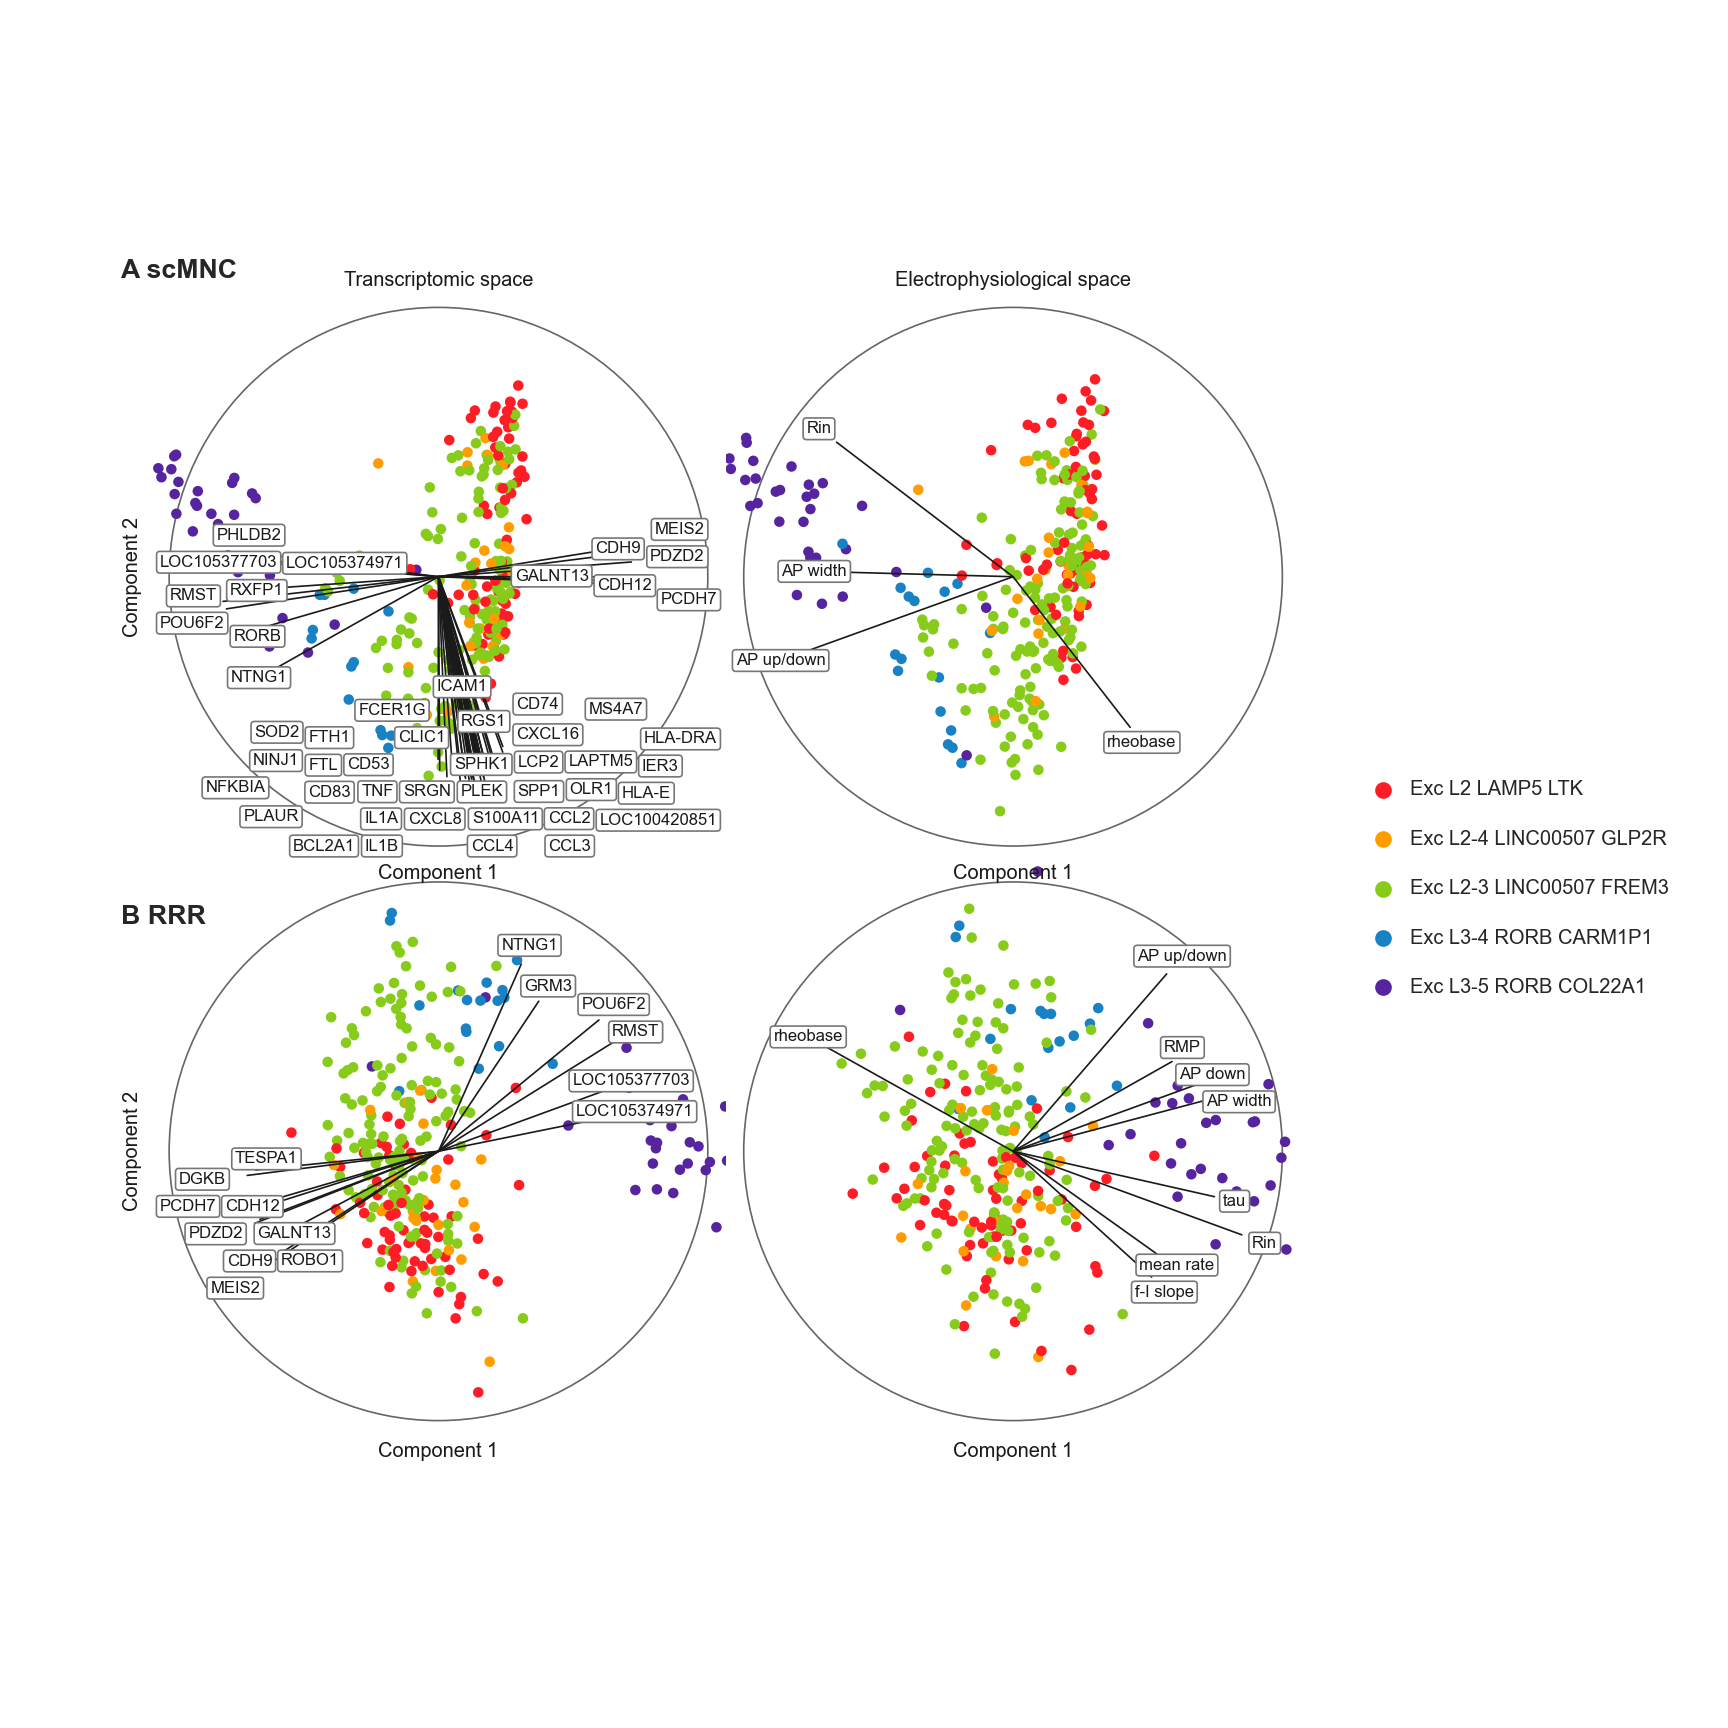

In [11]:
fig = plt.figure(figsize=(7.2, 7.2))

ax1 = plt.axes([.07,.15,.7,.7])
ax2 = plt.axes([.77+0.015,.4,.2,0.2])

plt.sca(ax1)

plt.xticks([])
plt.yticks([])

sns.despine(ax=ax1, left=True, bottom=True)

L = 3.2
scaleFactor = 3
s = 10
width = .475
col = np.array(pd.read_csv("./human_col.csv")['x'])
labelslabels = [geneExpr.index.array, [ShortephysY_name[e] for e in ephysY_name]]

for row, components in enumerate([[0,1], [2,3]]):

    Zx = xx[:,components]
    Zy = yy[:,components]
    Zx = Zx / np.std(Zx, axis=0)
    Zy = Zy / np.std(Zy, axis=0)

    for column, (Z,F,labels) in enumerate(zip([Zx,Zy], [X,Y], labelslabels)):
    
        plt.axes([0.07+(column*width+(1-2*width)/2)*0.7, 0.15+(.5-row*width)*0.7, width*0.7, width*0.7])
        plt.scatter(Z[:,0], Z[:,1], c=col, s=s, edgecolors='none')
        plt.xticks([])
        plt.yticks([])
        plt.xlim([-L,L])
        plt.ylim([-L,L])
        Rho = np.corrcoef(np.concatenate((Z[:,:2], F), axis=1), rowvar=False)[2:,:2]
        shownlabels = []
        
        for i in range(F.shape[1]):
            if np.sqrt(np.sum(Rho[i,:]**2)) > .67:
                plt.plot([0, scaleFactor*Rho[i,0]], [0, scaleFactor*Rho[i,1]], 
                         linewidth=.5, color='k', zorder=1)
                l = plt.text(scaleFactor*Rho[i,0]*1.1, scaleFactor*Rho[i,1]*1.1, labels[i],
                     ha='center', va='center', color='k', fontsize=5, zorder=10,
                     bbox=dict(facecolor='w', edgecolor='#777777', boxstyle='round', linewidth=.5, pad=.2))
                shownlabels.append(l)
 
        
        adjustlabels(fig, shownlabels)
        circ = plt.Circle((0,0), radius=scaleFactor, color=[.4, .4, .4], fill=False, linewidth=.5, zorder=-1)
        plt.gca().add_patch(circ)

plt.gcf().text(0.07+((1-2*width)/2+width/2)*0.7, .15+0.7*.978, 'Transcriptomic space', ha='center', fontsize=6, color='k')
plt.gcf().text(0.07+(.5+width/2)*0.7, .15+0.7*.978, 'Electrophysiological space', ha='center', fontsize=6, color='k')

plt.gcf().text(0.07+((1-2*width)/2+width/2)*0.7,.15+0.7* .01, 'Component 1', ha='center', fontsize=6, color='k')
plt.gcf().text(0.07+(.5+width/2)*0.7, .15+0.7*.01, 'Component 1', ha='center', fontsize=6, color='k')
plt.gcf().text(0.07+0.7*.002,.15+(.5+width/2)*0.7, 'Component 2', va='center', fontsize=6, color='k', rotation=90)


plt.gcf().text(0.07+((1-2*width)/2+width/2)*0.7, .15+ .4875*0.7, 'Component 1', ha='center', fontsize=6, color='k')
plt.gcf().text(0.07+(.5+width/2)*0.7, .15+ .4875*0.7, 'Component 1', ha='center', fontsize=6, color='k')
plt.gcf().text(0.07+.002*0.7, .15+((1-2*width)/2+width/2)*0.7, 'Component 2', va='center', fontsize=6, color='k', rotation=90)

fig.text(0.07+0, .15+ 1*0.7,  'A scMNC', fontsize=8, fontweight='bold', va='top')
fig.text(0.07+0, .15+ .45*0.7,  'B RRR', fontsize=8, fontweight='bold')

sns.despine(left=True, bottom=True)   

plt.sca(ax2)

plt.xlim(-0.04,0.09)
plt.ylim(-.75,4.5)
plt.xticks([])
plt.yticks([])

plt.plot(-0.03,(5-1)*.75,'o',markersize=4,c="#FF1D25")
plt.text(-0.02,(5-1)*0.75,"Exc L2 LAMP5 LTK",{'verticalalignment':'center','fontsize':6})

plt.plot(-0.03,(5-2)*.75,'o',markersize=4,c="#FF9D00")
plt.text(-0.02,(5-2)*0.75,"Exc L2-4 LINC00507 GLP2R",{'verticalalignment':'center','fontsize':6})

plt.plot(-0.03,(5-3)*.75,'o',markersize=4,c="#88CC1B")
plt.text(-0.02,(5-3)*0.75,"Exc L2-3 LINC00507 FREM3",{'verticalalignment':'center','fontsize':6})

plt.plot(-0.03,(5-4)*.75,'o',markersize=4,c="#1982C4")
plt.text(-0.02,(5-4)*0.75,"Exc L3-4 RORB CARM1P1",{'verticalalignment':'center','fontsize':6})

plt.plot(-0.03,(5-5)*.75,'o',markersize=4,c="#57249F")
plt.text(-0.02,(5-5)*0.75,"Exc L3-5 RORB COL22A1",{'verticalalignment':'center','fontsize':6})

sns.despine(ax=ax2, left=True, bottom=True)


plt.savefig('/Users/sj/Desktop/bibipot_elec.pdf', dpi=300)